In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, train
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,MEAN(prev.HOUR_APPR_PROCESS_START),MEAN(prev.CNT_PAYMENT),MEAN(prev.RATE_INTEREST_PRIVILEGED),MEAN(prev.DAYS_TERMINATION),MEAN(prev.DAYS_LAST_DUE),MEAN(prev.AMT_APPLICATION),MEAN(prev.AMT_CREDIT),COUNT(prev),NUM_UNIQUE(prev.NAME_CLIENT_TYPE),NUM_UNIQUE(prev.NAME_CONTRACT_STATUS),NUM_UNIQUE(prev.CODE_REJECT_REASON),NUM_UNIQUE(prev.NAME_TYPE_SUITE),NUM_UNIQUE(prev.NAME_CASH_LOAN_PURPOSE),NUM_UNIQUE(prev.FLAG_LAST_APPL_PER_CONTRACT),NUM_UNIQUE(prev.NAME_SELLER_INDUSTRY),NUM_UNIQUE(prev.WEEKDAY_APPR_PROCESS_START),NUM_UNIQUE(prev.NAME_YIELD_GROUP),NUM_UNIQUE(prev.CHANNEL_TYPE),NUM_UNIQUE(prev.NAME_CONTRACT_TYPE),NUM_UNIQUE(prev.NAME_GOODS_CATEGORY),NUM_UNIQUE(prev.NAME_PAYMENT_TYPE),NUM_UNIQUE(prev.NAME_PRODUCT_TYPE),NUM_UNIQUE(prev.PRODUCT_COMBINATION),NUM_UNIQUE(prev.NAME_PORTFOLIO),MODE(prev.NAME_CLIENT_TYPE),MODE(prev.NAME_CONTRACT_STATUS),MODE(prev.CODE_REJECT_REASON),MODE(prev.NAME_TYPE_SUITE),MODE(prev.NAME_CASH_LOAN_PURPOSE),MODE(prev.FLAG_LAST_APPL_PER_CONTRACT),MODE(prev.NAME_SELLER_INDUSTRY),MODE(prev.WEEKDAY_APPR_PROCESS_START),MODE(prev.NAME_YIELD_GROUP),MODE(prev.CHANNEL_TYPE),MODE(prev.NAME_CONTRACT_TYPE),MODE(prev.NAME_GOODS_CATEGORY),MODE(prev.NAME_PAYMENT_TYPE),MODE(prev.NAME_PRODUCT_TYPE),MODE(prev.PRODUCT_COMBINATION),MODE(prev.NAME_PORTFOLIO)
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,9.000000,24.000000,NaN,-17.000000,-25.000000,179055.000,179055.00,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,New,Approved,XAP,NaN,XAP,Y,Auto technology,SATURDAY,low_normal,Stone,Consumer loans,Vehicles,XNA,XNA,POS other with interest,POS
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,14.666667,10.000000,NaN,-1047.333333,-1054.333333,435436.500,484191.00,3.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,Refreshed,Approved,XAP,Family,XAP,Y,Consumer electronics,FRIDAY,middle,Country-wide,Consumer loans,Consumer Electronics,Cash through the bank,XNA,Cash X-Sell: low,POS
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,5.000000,4.000000,NaN,-714.000000,-724.000000,24282.000,20106.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,New,Approved,XAP,Unaccompanied,XAP,Y,Connectivity,FRIDAY,middle,Regional / Local,Consumer loans,Mobile,Cash through the bank,XNA,POS mobile without interest,POS
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,14.666667,23.000000,NaN,182481.750000,182477.500000,272203.260,291695.50,9.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,7.0,4.0,Repeater,Approved,XAP,Unaccompa

In [ ]:
test = pd.read_csv('test.csv')
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,MEAN(prev.DAYS_TERMINATION),MEAN(prev.AMT_DOWN_PAYMENT),MEAN(prev.AMT_GOODS_PRICE),MEAN(prev.DAYS_LAST_DUE),MEAN(prev.RATE_INTEREST_PRIMARY),MEAN(prev.DAYS_FIRST_DUE),MEAN(prev.NFLAG_LAST_APPL_IN_DAY),COUNT(prev),NUM_UNIQUE(prev.NAME_CLIENT_TYPE),NUM_UNIQUE(prev.NAME_CASH_LOAN_PURPOSE),NUM_UNIQUE(prev.NAME_PAYMENT_TYPE),NUM_UNIQUE(prev.NAME_SELLER_INDUSTRY),NUM_UNIQUE(prev.FLAG_LAST_APPL_PER_CONTRACT),NUM_UNIQUE(prev.NAME_CONTRACT_TYPE),NUM_UNIQUE(prev.NAME_CONTRACT_STATUS),NUM_UNIQUE(prev.PRODUCT_COMBINATION),NUM_UNIQUE(prev.NAME_YIELD_GROUP),NUM_UNIQUE(prev.WEEKDAY_APPR_PROCESS_START),NUM_UNIQUE(prev.CHANNEL_TYPE),NUM_UNIQUE(prev.NAME_PORTFOLIO),NUM_UNIQUE(prev.NAME_PRODUCT_TYPE),NUM_UNIQUE(prev.NAME_GOODS_CATEGORY),NUM_UNIQUE(prev.CODE_REJECT_REASON),NUM_UNIQUE(prev.NAME_TYPE_SUITE),MODE(prev.NAME_CLIENT_TYPE),MODE(prev.NAME_CASH_LOAN_PURPOSE),MODE(prev.NAME_PAYMENT_TYPE),MODE(prev.NAME_SELLER_INDUSTRY),MODE(prev.FLAG_LAST_APPL_PER_CONTRACT),MODE(prev.NAME_CONTRACT_TYPE),MODE(prev.NAME_CONTRACT_STATUS),MODE(prev.PRODUCT_COMBINATION),MODE(prev.NAME_YIELD_GROUP),MODE(prev.WEEKDAY_APPR_PROCESS_START),MODE(prev.CHANNEL_TYPE),MODE(prev.NAME_PORTFOLIO),MODE(prev.NAME_PRODUCT_TYPE),MODE(prev.NAME_GOODS_CATEGORY),MODE(prev.CODE_REJECT_REASON),MODE(prev.NAME_TYPE_SUITE)
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,-1612.000000,2520.00,24835.5000,-1619.000000,NaN,-1709.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Refreshed,XAP,Cash through the bank,Connectivity,Y,Consumer loans,Approved,POS mobile with interest,high,FRIDAY,Country-wide,POS,XNA,Mobile,XAP,Family
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,-460.000000,4464.00,44617.5000,-466.000000,NaN,-706.000000,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,0.0,New,XAP,Cash through the bank,Connectivity,Y,Cash loans,Approved,Cash,XNA,FRIDAY,Country-wide,POS,XNA,Mobile,XAP,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,-710.333333,3375.00,174495.0000,-715.666667,NaN,-1005.666667,1.0,4.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,1.0,1.0,Repeater,XAP,Cash through the bank,XNA,Y,Cash loans,Approved,Cash,middle,MONDAY,Credit and cash offices,POS,XNA,XNA,XAP,Unaccompanied
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,121182.666667,3750.00,82012.5000,121171.333333,NaN,-1271.000000,1.0,5.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0,5.0,3.0,2.0,3.0,3.0,2.0,4.0,2.0,1.0,Repeater,XAP,Cash through the bank,Consumer electronics,Y,Consumer loans,Appr

In [ ]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_DOWN_PAYMENT,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000850,-0.001500,0.001366,-0.000973,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000084,0.002344,0.000220,0.001557,-0.002070,0.001562,0.005905,-0.001463,0.004862,-0.002878,0.004851,...,0.001002,0.000898,0.037563,-0.018923,-0.002080,-0.000282,-0.001029,0.004726,0.000975,0.001038,0.000096,0.000006,0.006430,-0.002525,0.008337,-0.005262,-0.001407,-0.003228,0.001654,-0.003333,-0.001830,0.001162,0.002732,-0.002180,-0.002179,-0.002766,0.001508,-0.000720,0.000737,-0.000151,0.000543,0.001937,-0.001930,0.002389,0.002063,-0.001195,-0.001202,0.005627,-0.003318,-0.000697
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037230,0.078239,-0.044932,0.041975,0.051457,0.037612,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.155318,-0.160471,-0.178918,-0.029498,-0.022746,-0.009757,-0.022150,-0.018549,-0.034199,-0.019172,-0.044003,...,-0.022659,-0.002835,0.000296,0.031492,-0.002951,0.005858,-0.034538,0.010527,-0.025619,0.048476,-0.025235,0.000386,0.020143,-0.004373,0.030113,-0.005312,0.026895,-0.002481,0.017404,0.010846,0.045843,0.011839,-0.003230,0.027326,0.029339,0.010074,0.031106,0.038567,0.006232,0.001250,0.024032,0.012804,0.000918,0.024597,0.017793,-0.000019,0.021083,0.012988,-0.000423,0.008545
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025565,0.330938,-0.239818,0.183396,-0.028019,0.008494,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879161,0.025423,0.024781,-0.007292,-0.013319,0.008185,0.014835,0.020072,0.070650,0.069957,-0.138473,-0.018015,-0.042709,-0.013223,-0.008465,0.006902,0.030171,0.000139,-0.007060,-0.008344,-0.009707,...,-0.004488,-0.046307,-0.032841,0.000958,0.033497,0.063870,-0.022765,-0.013430,-0.012040,0.024351,-0.012010,0.002742,-0.000674,0.008676,0.004504,0.011918,-0.000171,0.012085,-0.003449,0.005081,0.009280,-0.026405,-0.009726,0.013730,0.014972,0.000965,-0.007263,0.005060,-0.045429,0.000864,0.006860,-0.072704,0.001879,0.007158,-0.084597,0.001726,0.008977,-0.089911,0.001568,0.011963
AMT_INCOME_TOTAL,-0.001820,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074793,0.027261,-0.064223,0.027806,0.008506,-0.117273,0.000325,0.063994,-0.017193,-0.008290,0.000159,0.038378,0.016342,-0.085465,-0.091735,0.036459,0.031191,0.062340,0.058059,0.003574,0.006431,0.008285,0.026231,0.060924,-0.030230,

In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'YEARS_BUILD_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_Overdue_duration_mean',
 'AMT_Overdue_duration0']

In [ ]:
train = train.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

In [ ]:
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [ ]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [ ]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [ ]:
test['Credit_income_ratio'] = test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']
test['Anuity_income_ratio'] = test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL'] 
test['Credit_term'] = test['AMT_ANNUITY']/test['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
test['Days_employed_age'] = test['DAYS_EMPLOYED']/test['DAYS_BIRTH']

In [ ]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_3                 -0.178918
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155318
ratio_approved               -0.064367
Days_employed_age            -0.055310
FLOORSMAX_AVG                -0.044003
STATUS_0                     -0.039693
REGION_POPULATION_RELATIVE   -0.037230
AMT_credit_consumerloans     -0.034538
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

In [ ]:
corr.dropna().tail(10)

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
CREDIT_ACTIVE_sum              0.061165
DAYS_CREDIT1                   0.064195
DAYS_EMPLOYED                  0.070075
DAYS_CREDIT2                   0.076813
DAYS_BIRTH                     0.078239
ratio_refused                  0.085185
DAYS_CREDIT3                   0.086596
TARGET                         1.000000
Name: TARGET, dtype: float64

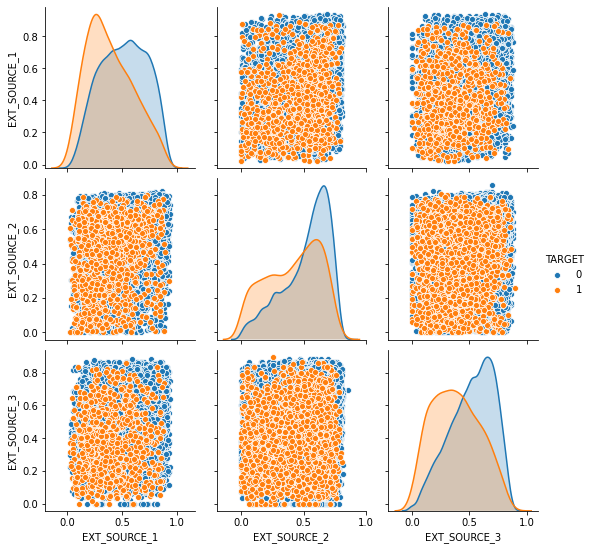

In [ ]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

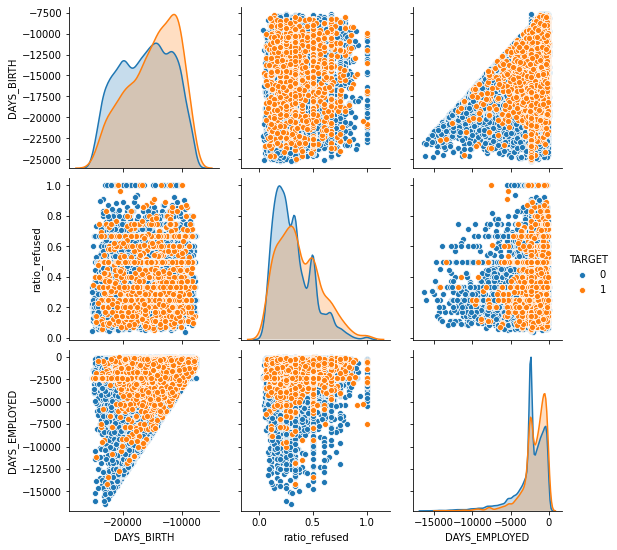

In [ ]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [ ]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [ ]:
# # LightGBM offers good accuracy with integer-encoded categorical features. 
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
cols = X.select_dtypes(include= object).columns
for col in cols:
    X[col] = class_le.fit_transform(X[col].values.astype(str))
    X[col] = X[col].astype('category')
tcols = test.select_dtypes(include= object).columns
for col in tcols:
    test[col] = class_le.fit_transform(test[col].values.astype(str))
    test[col] = test[col].astype('category')

In [ ]:
print(train.shape)
print(test.shape)

(307511, 212)
(48744, 211)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.05, random_state=1234)
pipeline = make_pipeline(StandardScaler(), LGBMClassifier())
params = {
  'lgbmclassifier__colsample_bytree': [0.45544541538547634],
  'lgbmclassifier__learning_rate': [0.09712737568777673],
  'lgbmclassifier__max_depth': [10],
  'lgbmclassifier__min_child_weight': [44.81416318834993],
  'lgbmclassifier__min_split_gain': [0.47913323843650946],
  'lgbmclassifier__num_leaves': [44],
  'lgbmclassifier__reg_alpha': [8.507126649843658],
  'lgbmclassifier__reg_lambda': [2.2113739093853257],
  'lgbmclassifier__subsample': [0.43342993037373423]
}
model = RandomizedSearchCV(pipeline, params, n_iter=1,  scoring='roc_auc', cv=5, n_jobs=-1, verbose = 100)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


0.7744256367912713

In [ ]:
model.best_params_

{'lgbmclassifier__colsample_bytree': 0.45544541538547634,
 'lgbmclassifier__learning_rate': 0.09712737568777673,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__min_child_weight': 44.81416318834993,
 'lgbmclassifier__min_split_gain': 0.47913323843650946,
 'lgbmclassifier__num_leaves': 44,
 'lgbmclassifier__reg_alpha': 8.507126649843658,
 'lgbmclassifier__reg_lambda': 2.2113739093853257,
 'lgbmclassifier__subsample': 0.43342993037373423}

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('LGBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)

LGBoost AUC 0.7853791158882399


In [ ]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [ ]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[22201  6066]
 [  936  1549]]
Precision: 0.20341431385423506
Recall 0.6233400402414487


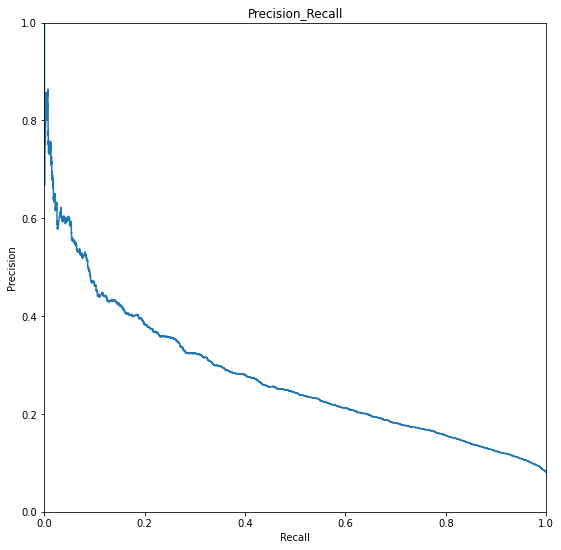

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.712848
1,1.000000,0.000402,inf,0.712848
2,1.000000,0.000805,inf,0.709184
3,0.957895,0.000805,5.901900e+04,0.688910
4,0.985560,0.002414,5.736233e+04,0.674258
...,...,...,...,...
4129,0.501129,0.999195,4.012281e+00,0.008304
4130,0.501230,0.999598,4.011475e+00,0.008298
4131,0.500315,0.999598,4.004136e+00,0.007185
4132,0.500416,1.000000,4.003331e+00,0.007109


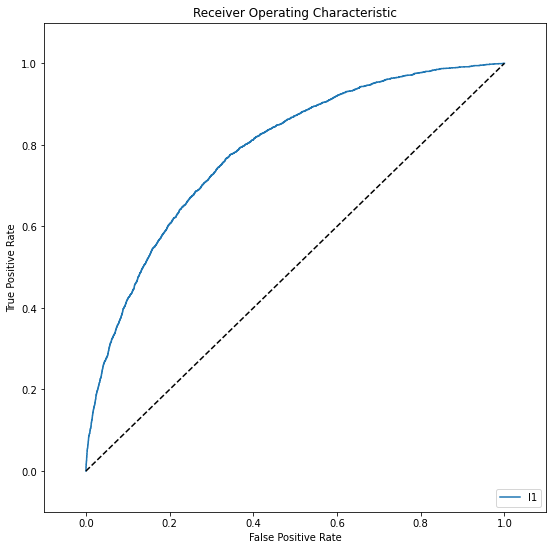

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# AUROC
roc_auc_score(y_test, pred)

0.7853791158882399

In [ ]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.2587800008494625

In [ ]:
lgbpred = model.predict_proba(test)
submit = test[['SK_ID_CURR']].copy()
submit['TARGET'] = lgbpred[:,1]
submit.to_csv('lgbkaggle.csv', index= False)